In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report


data = pd.read_json("../../data.json")
data.sample(2)

,index,mac,timestamp,no,rssi,raw,frequency,iq,angle,distance,capture,ref,a1,a2,a3,a2a1,a3a2,a3a1
12338,221,c300000a7a48,2024-10-26 09:53:21.545000+00:00,0,-45,0201061bff3906cafb01140000efff0201000000000000...,2402,"[-91, -175, 181, -72, 44, 187, -196, 33, 1, -1...",90,105.0,poli,"[-2.0503156188, -0.3785998017, 1.3397056595999...","[0.8741325074, -1.5707963268, 2.4287313618, -0...","[-1.7335939114, 2.2432748294, -0.1955368259000...","[1.8511692378, -0.6058578487, -2.9223751614, 0...","[-2.6077264188, -2.4691141509, -2.624268187700...","[-2.698422158, -2.8491326781, -2.7268383355, -...","[0.9770367304, 0.9649384781, 0.932078784000000..."
10548,44,c300000a7a48,2024-10-26 10:28:59.768000+00:00,0,-55,0201061bff3906cafb01140002ffec0102000000000000...,2402,"[-159, 96, -74, -170, 176, -39, 22, 187, -186,...",30,210.0,poli,"[2.5984030773, -1.9813537748, -0.2180672612, 1...","[-2.7326848246, 1.2287677411, -1.1729874871, 2...","[-1.7424992175, 2.2214232057, -0.1113027989, -...","[-0.0864888999, -2.4149503129, 1.4139043425, -...","[0.9901856072, 0.9926554647, 1.0616846882, 1.0...","[1.6560103176, 1.6468117886, 1.525207141400000...","[2.6461959246999998, 2.6394672532, 2.586891829..."


# PD in each line

In [2]:


tsamples =[]
tlabels =[]

vsamples=[]
vlabels=[]

tdataset, vdataset = train_test_split(data[data["capture"]== "tw"],test_size=0.2)

for row in tdataset.iterrows():
    for i in range(len(row[1]["a2a1"])):
        tsamples.append([
            row[1]["a2a1"][i], row[1]["a3a2"][i], row[1]["a3a1"][i]
        ])
        tlabels.append(row[1]["angle"])

for row in vdataset.iterrows():
    for i in range(len(row[1]["a2a1"])):
        vsamples.append([
            row[1]["a2a1"][i], row[1]["a3a2"][i], row[1]["a3a1"][i]
        ])
        vlabels.append(row[1]["angle"])

X_train = tsamples
y_train = [label//15 for label in tlabels ]

X_test = vsamples
y_test = [label//15 for label in vlabels ]


array_names= ([str(name) for name in range(0,180+15,15)])

In [5]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }


def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [6]:

#Splitting the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)



SCORE:                                                 
0.8320582493536643                                     
SCORE:                                                                            
0.8330607291721627                                                                
SCORE:                                                                            
0.809317786102464                                                                 
SCORE:                                                                            
0.8198174431488419                                                                
SCORE:                                                                            
0.8087374030496491                                                                
SCORE:                                                                            
0.8096871207724371                                                                
SCORE:                                                    

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [14]:
#Creating an XGBoost classifier
#model = xgb.XGBClassifier(**best_hyperparams)
model=xgb.XGBClassifier(colsample_bytree=best_hyperparams["colsample_bytree"],
                        gamma=best_hyperparams["gamma"],
                        max_depth=int(best_hyperparams["max_depth"]),
                        min_child_weight=best_hyperparams["min_child_weight"],
                        reg_alpha=best_hyperparams["reg_alpha"],
                        reg_lambda=best_hyperparams["reg_lambda"],
                        
                        )
#Training the model on the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.84637602104595, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5255505384558143,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [15]:
#Making predictions on the test set
predictions = model.predict(X_test)

#Calculating accuracy
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=array_names))

Accuracy: 0.8460402047169313

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.72      1650
          15       0.66      0.57      0.61      1551
          30       0.68      0.65      0.66      1430
          45       0.84      0.94      0.89      1375
          60       0.97      0.98      0.97      1375
          75       0.88      0.91      0.89      1342
          90       0.84      0.90      0.87      1243
         105       0.92      0.85      0.88      1595
         120       0.90      0.91      0.90      1606
         135       0.92      0.92      0.92      1364
         150       0.91      0.90      0.91      1331
         165       0.85      0.87      0.86      1485
         180       0.93      0.93      0.93      1606

    accuracy                           0.85     18953
   macro avg       0.85      0.85      0.85     18953
weighted avg       0.84      0.85      0.84     18953



In [ ]:
results_labels= []
results_values = []
for row in vdataset.iterrows():
    pred=[]
    for i in range(len(row[1]["a2a1"])):
        pred.append(model.predict([[row[1]["a2a1"][i], row[1]["a3a2"][i], row[1]["a3a1"][i]],])[0])
    results_labels.append((row[1]["angle"]//15))
    results_values.append(mode(pred)[0][0])

C:\Users\pedro\AppData\Local\Temp\ipykernel_8540\522828124.py:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  results_values.append(mode(pred)[0][0])


In [32]:
#Calculating accuracy
accuracy = accuracy_score(results_labels, results_values)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(results_labels, results_values, target_names=array_names))

Accuracy: 0.9071387115496228

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       138
          15       0.78      0.73      0.75       130
          30       0.89      0.78      0.83       151
          45       0.87      0.98      0.92       121
          60       0.97      0.97      0.97       120
          75       0.91      0.95      0.93       110
          90       0.87      0.96      0.91       113
         105       0.98      0.89      0.93       136
         120       0.95      0.98      0.96       150
         135       0.96      0.98      0.97       139
         150       0.97      0.90      0.93       127
         165       0.90      0.91      0.90       151
         180       0.97      0.95      0.96       137

    accuracy                           0.91      1723
   macro avg       0.91      0.91      0.91      1723
weighted avg       0.91      0.91      0.91      1723



In [ ]:
results = {str(l):[] for l in set(vlabels)}

for row in vdataset.iterrows():
    pred=[]
    for i in range(len(row[1]["a2a1"])):
        pred.append(model.predict([[row[1]["a2a1"][i], row[1]["a3a2"][i], row[1]["a3a1"][i]],])[0])
    results[str(row[1]["angle"])].append(mode(pred)[0][0]*15)

C:\Users\pedro\AppData\Local\Temp\ipykernel_8540\3640999782.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  results[str(row[1]["angle"])].append(mode(pred)[0][0]*15)


In [ ]:
for key, values in results.items():
    print(f"Angulo {key}\n" )
    for judgement in set(values):
        print(f"\t {judgement} = {100*values.count(judgement)/len(values)}% ")

Angulo 0

Angulo 165

Angulo 135

Angulo 105

Angulo 75

Angulo 45

Angulo 15

Angulo 180

Angulo 150

Angulo 120

Angulo 90

Angulo 60

Angulo 30



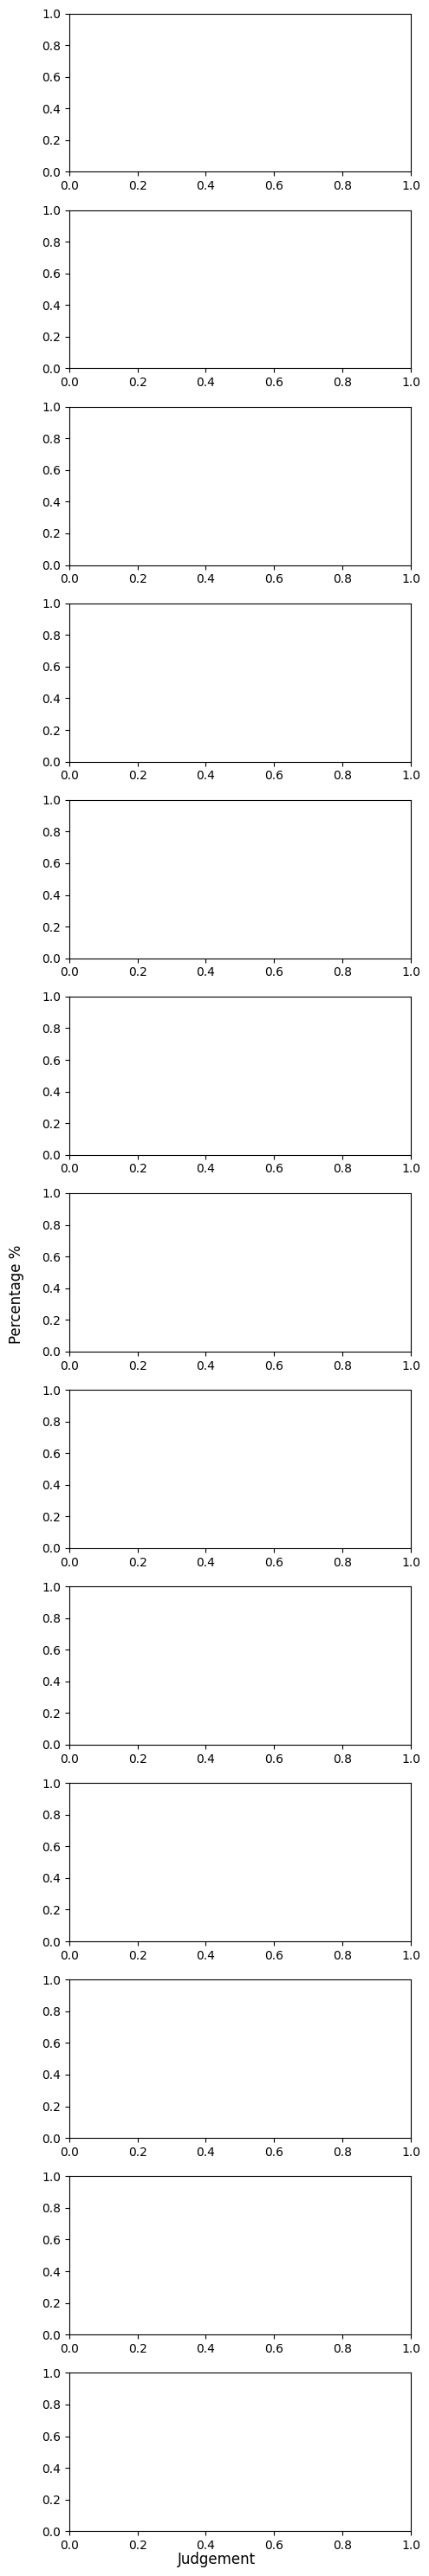

In [ ]:
fig, ax = plt.subplots(len(set(results.keys())),figsize=(5,30))
fig.set_tight_layout(True)

fig.supylabel("Percentage %")
fig.supxlabel("Judgement")


for i, pair in enumerate(results.items()):
    for judgement in set(pair[1]):
        ax[i].title.set_text(pair[0])
        ax[i].bar(judgement,100*pair[1].count(judgement)/len(pair[1]),0.8)
        plt.xlim(0,180)


In [ ]:
model.save_model("./xgb_classifier.json")